In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import time

from sklearn.model_selection  import train_test_split
from sklearn.metrics import r2_score , mean_squared_error , mean_absolute_error

import joblib

from sklearn.impute import  KNNImputer

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df_ai_tools = pd.read_csv("https://doping-hackathon-2025-data.s3.eu-central-1.amazonaws.com/hackathon_ai_tools_liste.csv")
df_chatbot_kullanim = pd.read_csv("https://doping-hackathon-2025-data.s3.eu-central-1.amazonaws.com/hackathon_chatbot_kullanim.csv")
df_content_tuketim = pd.read_csv("https://doping-hackathon-2025-data.s3.eu-central-1.amazonaws.com/hackathon_content_tuketim.csv")
df_cozucu_kullanim = pd.read_csv("https://doping-hackathon-2025-data.s3.eu-central-1.amazonaws.com/hackathon_cozucu_kullanim.csv")

df_dcp_12 = pd.read_csv("https://doping-hackathon-2025-data.s3.eu-central-1.amazonaws.com/hackathon_dcp_12_sinif.csv")
df_dcp_10 = pd.read_csv("https://doping-hackathon-2025-data.s3.eu-central-1.amazonaws.com/hackathon_dcp_10_sinif.csv")

df_v3_strateji_quiz_cozum = pd.read_csv("https://doping-hackathon-2025-data.s3.eu-central-1.amazonaws.com/hackathon_v3_strateji_quiz_cozum.csv")
df_v3_strateji_video_tuketim = pd.read_csv("https://doping-hackathon-2025-data.s3.eu-central-1.amazonaws.com/hackathon_v3_strateji_video_tuketim.csv")

df_simdi_anladim = pd.read_csv("https://doping-hackathon-2025-data.s3.eu-central-1.amazonaws.com/hackathon_simdi_anladim_kullanim.csv")


quiz_cozum = pd.read_csv("https://doping-hackathon-2025-data.s3.eu-central-1.amazonaws.com/hackathon_quiz_cozum.csv")

content_duration_second	watched_duration_second	progress_percentage tutarsızlık var !

Contentname gruplandırılır , label encoding

Sadece Matematik verisi var !

session_date to_datetime çevirdik.

day özelliği ile df_content_tuketim.session_date özelliği arasındaki ilişki incelenecek , aynı gün content tüketimi ve çözücü kullanımı analiz edilecek. Sadece Matematik için geçerli olur.
kalan dersler df_content_tuketim verisinde bulunmuyor !

In [11]:
df_v3_strateji_quiz_cozum.strategy_name.value_counts()

strategy_name
Reflekslerle Anlatım    160
Name: count, dtype: int64

ders_adi : 
Matematik          2261
Türkçe              771
Fizik               664
Kimya               492
Biyoloji            302
Coğrafya            276
Tarih               165
İngilizce            97
Felsefe              14
Fen Bilimleri        11
İnkılap Tarihi        3
Sosyal Bilgiler       2

* Birçok farklı ders için kullanılmış.

df_simdi_anladim[df_simdi_anladim["student_id"]==1002333]["kullanim"].sum() : Öğrenci şimdi anladım ı kaç defa kullandı.

attempt : kaç denemeye girmiş.
true_item_count : doğru sayısı
false_item_count : yanlış sayısı
empty_item_count : Boş soru sayısı


session_date  , quiz_name , curriculum_name.

sınava ne kadar kaldığı önemli  : sınav tarihi - o tarih --> integer 
bu değer önemli tarih verilerini sileriz.

In [15]:
quiz_cozum.curriculum_name.value_counts()

curriculum_name
TYT Reflekslerle Matematik    201076
AYT Reflekslerle Matematik     43861
Name: count, dtype: int64

In [136]:
# Kullanım verisi günlük 
df_content_tuketim['date_only'] = pd.to_datetime(df_content_tuketim['session_date']).dt.date

# Quiz verisi günlük
quiz_cozum['date_only'] = pd.to_datetime(quiz_cozum['session_date']).dt.date

In [141]:
df_content_agg = (
    df_content_tuketim
    .groupby(['student_id', 'curriculum_name', 'date_only'], as_index=False)
    .agg({
        'watched_duration_second': 'sum',  # o gün izlenen toplam saniye
        'content_duration_second': 'sum',  # içeriklerin toplam süresi
        'progress_percentage': 'mean',     # ortalama ilerleme yüzdesi
    })
)

df_quiz_agg = (
    quiz_cozum
    .groupby(['student_id', 'curriculum_name', 'date_only'], as_index=False)
    .agg({
        'attempt': 'count',          # kaç farklı deneme yapılmış
        'true_item_count': 'sum',    # toplam doğru
        'false_item_count': 'sum',   # toplam yanlış
        'empty_item_count': 'sum',   # toplam boş
    })
)

merged_data = pd.merge(
    df_content_agg,
    df_quiz_agg,
    on=['student_id', 'curriculum_name', 'date_only'],
    how='inner'  # 'outer' ile her iki taraftaki tüm günler tutulur
)

# Tarihleri datetime formatına çevirme 
df_dcp_12['start_date'] = pd.to_datetime(df_dcp_12['start_date'])
df_dcp_12['end_date'] = pd.to_datetime(df_dcp_12['end_date'])

df_content_tuketim['session_date'] = pd.to_datetime(df_content_tuketim['session_date'])

# Sadece öğrenci bazlı bir merge
merged_data = pd.merge(
    merged_data,
    df_dcp_12,
    on='student_id',
    how='inner'  
)

merged_data = merged_data.fillna(0)

In [17]:
# 1. student_id'ye göre grupla ve attempt sayısını hesapla
attempt_counts = merged_data.groupby('student_id')['attempt'].sum().reset_index()

# 2. attempt sayısı 10'dan fazla olan student_id'leri bul
high_attempt_students = attempt_counts[attempt_counts['attempt'] > 10]['student_id']

# 3. Bu öğrencileri orijinal DataFrame'den çıkar
filtered_df = merged_data[~merged_data['student_id'].isin(high_attempt_students)]

# Sonucu görüntüle
filtered_df

,student_id,curriculum_name,date_only,watched_duration_second,content_duration_second,progress_percentage,attempt,true_item_count,false_item_count,empty_item_count,start_date,end_date,total_progress_percentage
32,1000262,TYT Reflekslerle Matematik,2024-10-16,45,872,0.625000,1,1,1,0,2024-09-29 03:00:00+03:00,2025-07-13 00:00:00+03:00,0.00
33,1000623,AYT Reflekslerle Matematik,2024-12-04,2401,4593,1.000000,1,1,5,0,2025-01-03 21:05:45.007000+03:00,2025-02-07 00:00:00+03:00,0.03
34,1000623,TYT Reflekslerle Matematik,2024-10-24,465,738,1.000000,1,1,4,3,2025-01-03 21:05:45.007000+03:00,2025-02-07 00:00:00+03:00,0.03
35,1000623,TYT Reflekslerle Matematik,2024-10-27,1605,4790,0.485000,1,2,6,0,2025-01-03 21:05:45.007000+03:00,2025-02-07 00:00:00+03:00,0.03
36,1000658,AYT Reflekslerle Matematik,2024-09-22,1565,2293,1.000000,1,1,3,7,2024-09-11 22:31:44+03:00,2025-03-19 00:00:00+03:00,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59595,1999856,TYT Reflekslerle Matematik,2024-09-14,4288,4832,0.788000,1,0,0,15,2025-01-14 03:00:00+03:00,2025-02-27 00:00:00+03:00,0.00
59596,1999987,AYT Reflekslerle Matematik,2024-10-16,399,1993,0.505000,3,11,6,6,2025-01-25 18:28:21.290000+03:00,2025-03-18 00:00:00+03:00,0.00
59597,1999987,AYT Reflekslerle Matematik,2025-01-07,517,2383,1.000000,1,4,2,0,2025-01-25 18:28:21.290000+03:00,2025-03-18 00:00:00+03:00,0.00
59598,1999987,AYT Reflekslerle Matematik,2025-01-15,203,3945,0.316667,2,18,3,1,2025-01-25 18:28:21.290000+03:00,2025-03-18 00:00:00+03:00,0.00


dcp_12 , quiz ve content birleşimi.

In [77]:
sampled_df = filtered_df.sample(n=150, random_state=42)  # random_state ile tekrarlanabilirlik sağlanır
sampled_df = sampled_df.reset_index(drop = True) # rastgele 1100 kişi anketi doldurmuş gibi yapacağız. O yüzden indekslerin şu anda önemi yok.

In [78]:
stress_df = pd.read_csv('preprocessed_data.csv')
stress_df.head()

,"1- Son bir ay içinde, beklenmedik bir şeylerin olması nedeniyle ne sıklıkta rahatsızlık duydunuz?","2- Son bir ay içinde ne sıklıkta, yaşamınızdaki önemli şeyleri kontrol edemediğinizi hissettiniz?","3- Son bir ay içinde kendinizi ne sıklıkta, gergin ve stresli hissettiniz?","4- Son bir ay içinde, yaşamınızdaki can sıkıcı durumlarla ne sıklıkta başarılı bir biçimde baş ettiniz?","5- Son bir ay içinde ne sıklıkta, yaşamınızda meydana gelen önemli değişikliklerle etkili bir biçimde başa çıktığınızı hissettiniz?","6- Son bir ay içinde ne sıklıkta, kişisel sorunlarınızla baş etme yeteneğinizden emin oldunuz?","7- Son bir ay içinde ne sıklıkta, işlerin istediğiniz gibi gittiğini hissettiniz?","8- Son bir ay içinde ne sıklıkta, yapmak zorunda olduğunuz her şeyin üstesinden gelemeyeceğinizi düşündünüz?",9- Son bir ay içinde yaşamınızdaki rahatsız edici olayları ne sıklıkta kontrol edebildiniz?,"10- Son bir ay içinde ne sıklıkta, yaşamınızdaki olaylara hakim olduğunuzu hissettiniz?","11- Son bir ay içinde, kontrolünüz dışında gerçekleşen şeylerden dolayı ne sıklıkta öfkelendiniz?","12- Son bir ay içinde ne sıklıkta, üstesinden gelmek zorunda olduğunuz şeyler üzerinde düşündünüz?",13- Zamanınızı nasıl geçirdiğinizi son bir ay içinde ne sıklıkta kontrol edebildiniz?,"14- Son bir ay içinde ne sıklıkta, güçlüklerin, üstesinden gelemeyeceğiniz kadar çoğaldığını hissettiniz?",score,factor_1_score,factor_2_score,stress,factor_1,factor_2
0,2,2,3,3,3,2,2,1,2,2,1,4,3,2,26,10,16,0,0,1
1,1,2,2,3,3,3,2,1,2,3,1,4,3,2,22,8,14,0,0,1
2,1,2,3,4,4,3,2,0,3,3,0,4,3,1,17,4,13,0,0,0
3,0,3,3,2,2,1,1,3,2,2,3,4,3,3,34,15,19,1,1,1
4,1,1,1,3,0,1,1,3,3,2,0,2,2,2,26,16,10,0,1,0


In [148]:
X = stress_df.drop(['factor_1_score','factor_1_score','factor_1','score' , 'stress' , 'factor_2' , 'factor_2_score'] , axis = 1 )
y = stress_df['score']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2, random_state=42)


# Define models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GBM': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
}

results = []

# Train and evaluate models
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    train_time = end_time - start_time

    results.append({'Model': name, 'MSE': mse, 'R2': r2, 'Train Time (s)': train_time})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Rank models by MSE
results_df.head()

,Model,MSE,R2,Train Time (s)
0,Random Forest,4.872187,0.943592,0.154689
1,GBM,4.338576,0.949770,0.099743
2,XGBoost,6.585463,0.923756,0.080372


In [116]:
model = RandomForestRegressor(n_estimators=200)
model = model.fit(X_train,y_train) # model train

y_pred = model.predict(X_test) # predict

mse = mean_squared_error(y_test , y_pred)
r2 = r2_score(y_test , y_pred)

In [117]:
print(mse)
print(r2)

5.375697499999997
0.9377620696974376


In [125]:
feature_names = X.columns
importances = model.feature_importances_

feature_importance = pd.DataFrame(importances, feature_names)

In [126]:
feature_importance # Burda feature importancelere bakarak stres seviyesine hangi soruların ne kadar etkisi olmuş onu inceliyoruz

,0
"1- Son bir ay içinde, beklenmedik bir şeylerin olması nedeniyle ne sıklıkta rahatsızlık duydunuz?",0.037045
"2- Son bir ay içinde ne sıklıkta, yaşamınızdaki önemli şeyleri kontrol edemediğinizi hissettiniz?",0.066930
"3- Son bir ay içinde kendinizi ne sıklıkta, gergin ve stresli hissettiniz?",0.051693
"4- Son bir ay içinde, yaşamınızdaki can sıkıcı durumlarla ne sıklıkta başarılı bir biçimde baş ettiniz?",0.012720
"5- Son bir ay içinde ne sıklıkta, yaşamınızda meydana gelen önemli değişikliklerle etkili bir biçimde başa çıktığınızı hissettiniz?",0.027073
"6- Son bir ay içinde ne sıklıkta, kişisel sorunlarınızla baş etme yeteneğinizden emin oldunuz?",0.057883
"7- Son bir ay içinde ne sıklıkta, işlerin istediğiniz gibi gittiğini hissettiniz?",0.013636
"8- Son bir ay içinde ne sıklıkta, yapmak zorunda olduğunuz her şeyin üstesinden gelemeyeceğinizi düşündünüz?",0.139156
9- Son bir ay içinde yaşamınızdaki rahatsız edici olayları ne sıklıkta kontrol edebildiniz?,0.144317
"10- Son bir ay içinde ne sıklıkta, yaşamınızdaki olaylara hakim olduğunuzu hissettiniz?",0.298912


In [131]:
joblib.dump(model, 'random_forest_model.pkl') # modeli streamlite koymak için kaydedelim

['random_forest_model.pkl']

In [79]:
if len(sampled_df) == len(stress_df):
    my_data = pd.concat([sampled_df, stress_df], axis=1)
else:
    print(f"DataFrame'ler aynı uzunlukta değil! filtered_df uzunluğu: {len(filtered_df)}, stress_df uzunluğu: {len(stress_df)}")

In [80]:
my_synthetic_data = my_data

In [81]:
my_synthetic_data.to_csv('my_synthetic_file.csv', index=False)

In [82]:
my_synthetic_data['true_ratio'] = my_synthetic_data['true_item_count'] / (my_synthetic_data['true_item_count'] +  my_synthetic_data['false_item_count'] +  my_synthetic_data['empty_item_count'])

In [83]:
# Bins ve Labels tanımlama
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
labels = [1, 2, 3, 4, 5]

# pd.cut ile kategorilere ayırma
my_synthetic_data['true_ratio_cat'] = pd.cut(my_synthetic_data['true_ratio'], bins=bins, labels=labels, include_lowest=True)


In [85]:
my_synthetic_data.head(10)

,student_id,curriculum_name,date_only,watched_duration_second,content_duration_second,progress_percentage,attempt,true_item_count,false_item_count,empty_item_count,start_date,end_date,total_progress_percentage,"1- Son bir ay içinde, beklenmedik bir şeylerin olması nedeniyle ne sıklıkta rahatsızlık duydunuz?","2- Son bir ay içinde ne sıklıkta, yaşamınızdaki önemli şeyleri kontrol edemediğinizi hissettiniz?","3- Son bir ay içinde kendinizi ne sıklıkta, gergin ve stresli hissettiniz?","4- Son bir ay içinde, yaşamınızdaki can sıkıcı durumlarla ne sıklıkta başarılı bir biçimde baş ettiniz?","5- Son bir ay içinde ne sıklıkta, yaşamınızda meydana gelen önemli değişikliklerle etkili bir biçimde başa çıktığınızı hissettiniz?","6- Son bir ay içinde ne sıklıkta, kişisel sorunlarınızla baş etme yeteneğinizden emin oldunuz?","7- Son bir ay içinde ne sıklıkta, işlerin istediğiniz gibi gittiğini hissettiniz?","8- Son bir ay içinde ne sıklıkta, yapmak zorunda olduğunuz her şeyin üstesinden gelemeyeceğinizi düşündünüz?",9- Son bir ay içinde yaşamınızdaki rahatsız edici olayları ne sıklıkta kontrol edebildiniz?,"10- Son bir ay içinde ne sıklıkta, yaşamınızdaki olaylara hakim olduğunuzu hissettiniz?","11- Son bir ay içinde, kontrolünüz dışında gerçekleşen şeylerden dolayı ne sıklıkta öfkelendiniz?","12- Son bir ay içinde ne sıklıkta, üstesinden gelmek zorunda olduğunuz şeyler üzerinde düşündünüz?",13- Zamanınızı nasıl geçirdiğinizi son bir ay içinde ne sıklıkta kontrol edebildiniz?,"14- Son bir ay içinde ne sıklıkta, güçlüklerin, üstesinden gelemeyeceğiniz kadar çoğaldığını hissettiniz?",score,factor_1_score,factor_2_score,stress,factor_1,factor_2,true_ratio,true_ratio_cat
0,1562985,TYT Reflekslerle Matematik,2024-12-02,2304,3032,1.000000,1,11,7,4,2024-12-19 03:00:00+03:00,2025-04-13 00:00:00+03:00,0.23,2,2,3,3,3,2,2,1,2,2,1,4,3,2,26,10,16,0,0,1,0.500000,3
1,1678723,TYT Reflekslerle Matematik,2024-11-08,990,7155,0.817333,1,5,2,0,2025-01-29 03:00:00+03:00,2031-03-08 00:00:00+03:00,0.00,1,2,2,3,3,3,2,1,2,3,1,4,3,2,22,8,14,0,0,1,0.714286,4
2,1102295,TYT Reflekslerle Matematik,2024-09-22,3354,10358,0.879000,1,0,1,0,2024-09-21 14:38:34.270000+03:00,2025-06-22 00:00:00+03:00,0.17,1,2,3,4,4,3,2,0,3,3,0,4,3,1,17,4,13,0,0,0,0.000000,1
3,1789844,TYT Reflekslerle Matematik,2024-09-28,5282,7422,0.964118,3,4,1,1,2024-12-13 22:28:20.541000+03:00,2025-02-14 00:00:00+03:00,0.00,0,3,3,2,2,1,1,3,2,2,3,4,3,3,34,15,19,1,1,1,0.666667,4
4,1800994,TYT Reflekslerle Matematik,2024-12-10,844,953,1.000000,1,4,2,1,2025-01-28 03:00:00+03:00,2025-04-15 00:00:00+03:00,0.00,1,1,1,3,0,1,1,3,3,2,0,2,2,2,26,16,10,0,1,0,0.571429,3
5,1327326,AYT Reflekslerle Matematik,2024-10-06,649,5033,0.909091,2,7,2,7,2025-01-11 18:41:15.652000+03:00,2025-03-29 00:00:00+03:00,0.03,2,3,3,1,1,2,0,3,1,1,2,3,2,3,39,19,20,1,1,1,0.437500,3
6,1491974,TYT Reflekslerle Matematik,2024-09-18,2975,5761,0.867778,1,0,2,0,2025-01-22 14:47:34.244000+03:00,2025-03-15 00:00:00+03:00,0.01,2,3,3,2,2,2,2,2,2,3,2,3,2,2,30,13,17,1,0,1,0.000000,1
7,1479114,TYT Reflekslerle Matematik,2024-10-18,465,7651,1.000000,1,5,2,0,2024-09-25 11:11:16+03:00,2025-02-26 00:00:00+03:00,0.30,0,3,2,1,0,0,1,3,2,2,0,2,1,0,31,21,10,1,1,0,0.714286,4
8,1748760,TYT Reflekslerle Matematik,2024-10-22,1971,6661,0.953750,2,2,8,0,2024-10-09 13:39:48.292000+03:00,2025-02-14 00:00:00+03:00,0.28,3,3,3,2,2,3,2,2,2,1,4,4,3,3,35,13,22,1,0,1,0.200000,1
9,1002788,TYT Reflekslerle Matematik,2024-10-15,5362,5806,1.000000,2,4,0,2,2025-01-17 03:00:00+03:00,2025-05-27 00:00:00+03:00,0.01,3,3,3,2,2,2,1,3,2,1,3,3,2,3,37,16,21,1,1,1,0.666667,4


In [70]:
my_synthetic_data['progress_percentage'] = my_synthetic_data.groupby('student_id')['total_progress_percentage'].transform('mean').sort_values(ascending = False)


In [89]:
my_synthetic_data['is_stressed'] = my_synthetic_data['stress']

In [90]:
core = ['student_id' , 'date_only' , 'is_stressed', 'true_ratio_cat' , 'progress_percentage']
my_core_data = my_synthetic_data[core].set_index('date_only').sort_index(ascending=False)

In [150]:
my_core_data.to_csv("stres.csv",index=False)

progress_percentage --> Öğrencinin o zamana akdar tamamladığı içerik yüzdesi. Ne kadar çalışmış.

In [55]:
my_core_data.groupby('date_only').agg({'stress_level': 'mean', 'true_ratio_cat': 'mean'})

,stress_level,true_ratio_cat
date_only,,
2024-09-03,2.000000,1.000000
2024-09-04,0.000000,4.000000
2024-09-05,2.000000,3.000000
2024-09-07,2.000000,4.000000
2024-09-08,0.000000,4.000000
2024-09-09,1.500000,2.000000
2024-09-10,0.500000,2.000000
2024-09-11,0.600000,2.600000
2024-09-12,0.666667,2.333333


In [61]:
my_core_data.student_id.nunique() 

1031

stress_level
0    373
2    369
1    358
Name: count, dtype: int64

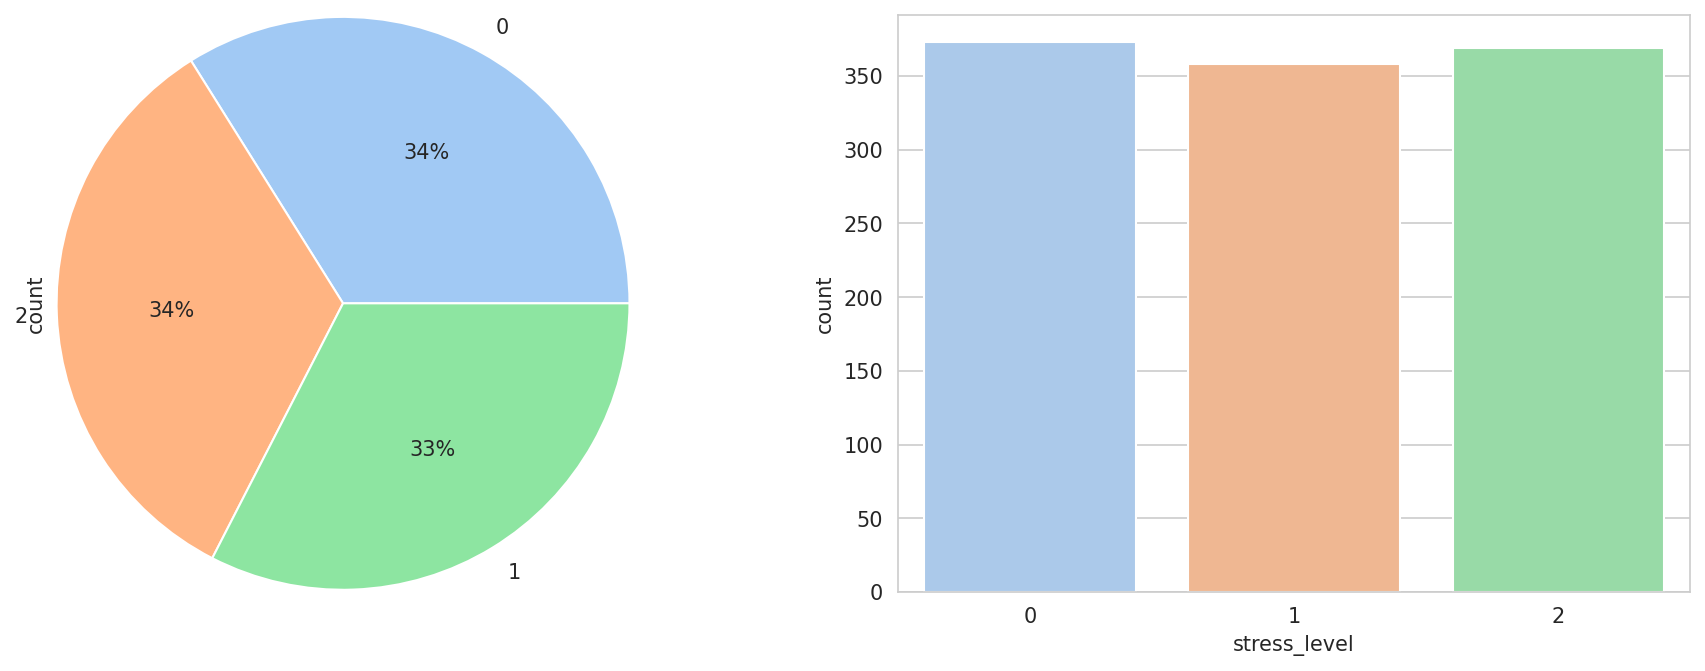

In [63]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5), dpi=150)

plt.subplot(121)
my_core_data['stress_level'].value_counts().plot(kind='pie', autopct='%2.f%%', radius=1.24, colors=sns.color_palette('pastel'))

plt.subplot(122)
sns.countplot(data=my_core_data, x='stress_level', palette='pastel')
my_core_data['stress_level'].value_counts()

true_ratio_cat
3    339
1    261
2    241
4    177
5     82
Name: count, dtype: int64

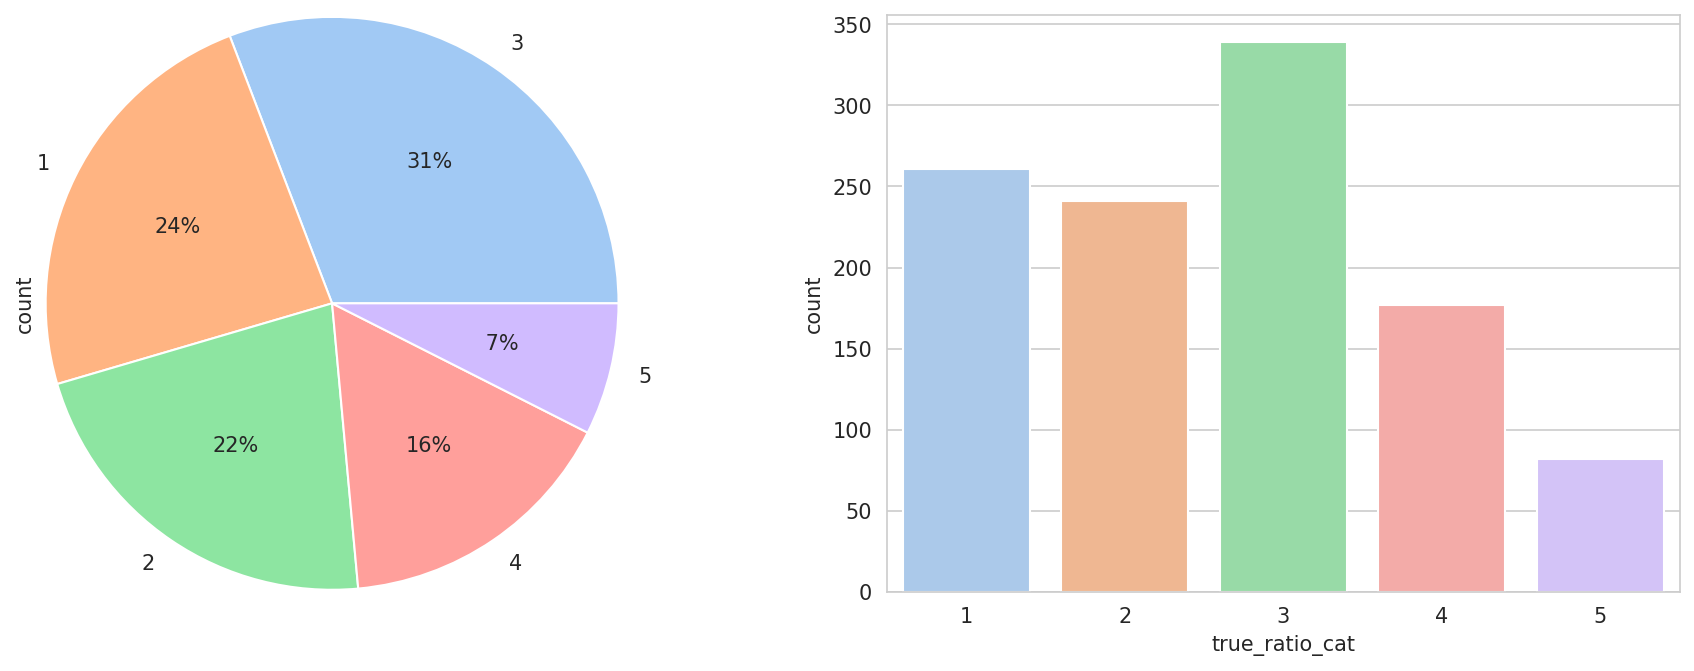

In [64]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5), dpi=150)

plt.subplot(121)
my_core_data['true_ratio_cat'].value_counts().plot(kind='pie', autopct='%2.f%%', radius=1.24, colors=sns.color_palette('pastel'))

plt.subplot(122)
sns.countplot(data=my_core_data, x='true_ratio_cat', palette='pastel')
my_core_data['true_ratio_cat'].value_counts()

<Axes: xlabel='progress_percentage', ylabel='Count'>

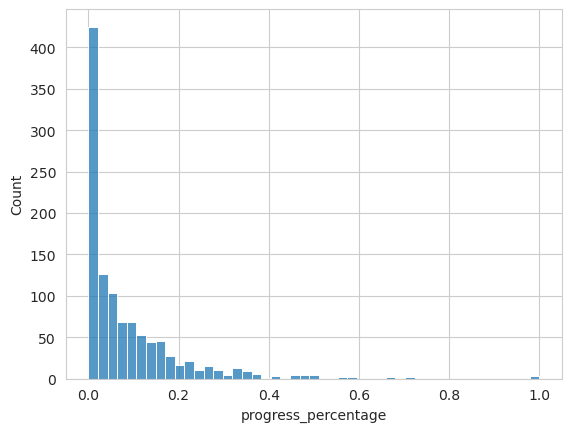

In [73]:
sns.histplot(data = my_core_data , x = 'progress_percentage')